In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import itertools
import spacy
import os
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

In [2]:
# File paths
files = {
    'data8B/mistral_readability_results_zero-shot.csv',
    'data8B/mistral_readability_results_few-shot.csv',
    'data8B/mistral_readability_results_two-step.csv',
    'data8B/mistral_readability_results_cot.csv',
    'data8B/llama_readability_results_zero-shot.csv',
    'data8B/llama_readability_results_few-shot.csv',
    'data8B/llama_readability_results_two-step.csv',
    'data8B/llama_readability_results_cot.csv',
    'llama_readability_results_cot_advanced.csv',
    'mistral_readability_results_cot_advanced.csv'
}

# Load and label data
dfs = []
for path in files:
    df = pd.read_csv(path)
    dfs.append(df)

# Combine into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,ARI,SMOG,Gunning Fog,Coleman-Liau,Spache,Linsear Write
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,5.726866,7.554174,7.151045,6.229851,4.525415,6.300
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,2.642871,5.873415,3.803297,3.912500,2.514484,3.000
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,5.164478,7.168622,6.554030,5.623881,3.755266,5.875
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,4.500333,7.168622,5.388889,5.628148,3.317102,5.625
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,10.892034,12.384807,12.679661,11.832203,5.761123,7.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Few-Shot,nutrition,Graduate,200,llama3.1:8b,"Example 1:\nCosmology (from the Greek kosmos, ...",NaN,"Here's a paragraph on ""nutrition"" written in a...",20.875211,-0.456526,23.269474,21.903100,26.107368,18.522368,9.255663,21.250
1596,Few-Shot,nutrition,Research,50,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Here's a paragraph about nutrition:\n\nNutriti...,21.326923,-11.531923,23.634231,21.640514,25.784615,21.653846,9.135769,23.500
1597,Few-Shot,nutrition,Research,100,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,The study of nutrition dates back to ancient c...,17.522392,3.989361,19.394845,18.458007,22.605361,20.284536,8.096049,16.900
1598,Few-Shot,nutrition,Research,150,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Example:\n\nNutritional systems have been unde...,18.220208,2.853907,18.239555,19.287187,23.463009,17.935099,8.436863,17.000


In [3]:
# Defined Readability levels
READABILITY_LEVELS = [
    "Early Elementary",
    "Upper Elementary",
    "Middle School",
    "High School",
    "College",
    "Advanced College",
    "Graduate",
    "Research"
]

In [4]:
# Mapping Metric Value - Readability Level
FLESCH_KINCAID_GRADE = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

FLESCH_READING_EASE = {
    (90, 100): "Upper Elementary",
    (80, 90): "Upper Elementary",
    (70, 80): "Middle School",
    (65, 70): "Middle School",
    (60, 65): "High School",
    (50, 60): "High School",
    (40, 50): "High School",
    (30, 40): "High School",
    (0, 30): "College"
}

ARI = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research",
    19: "Research"
}

COLEMAN_LIAU = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

GUNNING_FOG = {
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research",
    19: "Research"
}

SMOG_INDEX = {
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Advanced College",
    17: "Graduate",
    18: "Research"
}

SPACHE = {
    1: "Early Elementary",
    2: "Early Elementary",
    3: "Early Elementary",
    4: "Upper Elementary"
}

LINSEAR_WRITE = {
    4: "Upper Elementary",
    5: "Upper Elementary",
    6: "Upper Elementary",
    7: "Middle School",
    8: "Middle School",
    9: "High School",
    10: "High School",
    11: "High School",
    12: "High School",
    13: "College",
    14: "College",
    15: "Advanced College",
    16: "Graduate"
}

In [5]:
# Mapping to convert score to level category
def map_reading_level(value, mapping, is_range=False):
    if pd.isna(value):
        return None
    if is_range:
        for rng, level in mapping.items():
            if rng[0] <= value < rng[1]:
                return level
    else:
        value = int(round(value))
        return mapping.get(value, "Unknown")
    return "Unknown"

In [6]:
# Apply mapping to the metric values
df_all['Level_FleschKincaid'] = df_all['Flesch-Kincaid'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_FleschEase'] = df_all['Flesch Ease'].apply(lambda x: map_reading_level(x, FLESCH_READING_EASE, is_range=True))
df_all['Level_ARI'] = df_all['ARI'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_ColemanLiau'] = df_all['Coleman-Liau'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_GunningFog'] = df_all['Gunning Fog'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_SMOG'] = df_all['SMOG'].apply(lambda x: map_reading_level(x, FLESCH_KINCAID_GRADE))
df_all['Level_Spache'] = df_all['Spache'].apply(lambda x: map_reading_level(x, SPACHE))
df_all['Level_LinsearWrite'] = df_all['Linsear Write'].apply(lambda x: map_reading_level(x, LINSEAR_WRITE))

In [7]:
df_all.head(5)

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Spache,Linsear Write,Level_FleschKincaid,Level_FleschEase,Level_ARI,Level_ColemanLiau,Level_GunningFog,Level_SMOG,Level_Spache,Level_LinsearWrite
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,...,4.525415,6.300,Upper Elementary,Middle School,Upper Elementary,Upper Elementary,Middle School,Middle School,Unknown,Upper Elementary
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,...,2.514484,3.000,Early Elementary,Upper Elementary,Early Elementary,Upper Elementary,Upper Elementary,Upper Elementary,Early Elementary,Unknown
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,...,3.755266,5.875,Upper Elementary,Upper Elementary,Upper Elementary,Upper Elementary,Middle School,Middle School,Upper Elementary,Upper Elementary
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,...,3.317102,5.625,Upper Elementary,Upper Elementary,Upper Elementary,Upper Elementary,Upper Elementary,Middle School,Early Elementary,Upper Elementary
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,...,5.761123,7.375,High School,High School,High School,High School,College,High School,Unknown,Middle School


In [8]:
# Functions to compute signed distance and Normalized Absolute Distance
def compute_distance(row_level, target_level):
    if pd.notnull(row_level) and pd.notnull(target_level):
        try:
            return float(row_level) - float(target_level)
        except:
            return None
    return None

def compute_distance_range(row_level, target_level, metric_name):
    if pd.notnull(row_level) and pd.notnull(target_level):
        try:
            raw_distance = abs(float(row_level) - float(target_level))
            range_val = READABILITY_RANGES.get(metric_name)
            if range_val:
                return raw_distance / range_val
            else:
                return raw_distance  # fallback if range not defined
        except Exception:
            return None
    return None

In [9]:
# Reverse Mapping Target Level - Metric Value
FLESCH_KINCAID_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0,
    "Legal / Medical": 20
}

FLESCH_EASE_TARGET_MAP = {
    "Upper Elementary": 95,
    "Middle School": 75,
    "High School": 45,
    "College": 15
}

ARI_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.5
}

COLEMAN_LIAU_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0
}

GUNNING_FOG_TARGET_MAP = {
    "Upper Elementary": 6.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.5
}

SMOG_TARGET_MAP = {
    "Upper Elementary": 6.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.5,
    "Graduate": 17.0,
    "Research": 18.0
}

SPACHE_TARGET_MAP = {
    "Early Elementary": 2.0,
    "Upper Elementary": 4.0
}

LINSEAR_WRITE_TARGET_MAP = {
    "Upper Elementary": 5.0,
    "Middle School": 7.5,
    "High School": 10.5,
    "College": 13.5,
    "Advanced College": 15.0,
    "Graduate": 16.0
}

df_all['Target Level Flesch-Kincaid'] = df_all['Target Level'].map(FLESCH_KINCAID_TARGET_MAP)
df_all['Target Level Flesch Ease'] = df_all['Target Level'].map(FLESCH_EASE_TARGET_MAP)
df_all['Target Level ARI'] = df_all['Target Level'].map(ARI_TARGET_MAP)
df_all['Target Level Coleman-Liau'] = df_all['Target Level'].map(COLEMAN_LIAU_TARGET_MAP)
df_all['Target Level Gunning Fog'] = df_all['Target Level'].map(GUNNING_FOG_TARGET_MAP)
df_all['Target Level SMOG'] = df_all['Target Level'].map(SMOG_TARGET_MAP)
df_all['Target Level Spache'] = df_all['Target Level'].map(SPACHE_TARGET_MAP)
df_all['Target Level Linsear Write'] = df_all['Target Level'].map(LINSEAR_WRITE_TARGET_MAP)

In [10]:
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Level_Spache,Level_LinsearWrite,Target Level Flesch-Kincaid,Target Level Flesch Ease,Target Level ARI,Target Level Coleman-Liau,Target Level Gunning Fog,Target Level SMOG,Target Level Spache,Target Level Linsear Write
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,...,Unknown,Upper Elementary,2.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,...,Early Elementary,Unknown,2.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,...,Upper Elementary,Upper Elementary,2.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,...,Early Elementary,Upper Elementary,2.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,...,Unknown,Middle School,5.0,95.0,5.0,5.0,6.0,6.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Few-Shot,nutrition,Graduate,200,llama3.1:8b,"Example 1:\nCosmology (from the Greek kosmos, ...",NaN,"Here's a paragraph on ""nutrition"" written in a...",20.875211,-0.456526,...,Unknown,Unknown,17.0,NaN,17.0,17.0,17.0,17.0,NaN,16.0
1596,Few-Shot,nutrition,Research,50,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Here's a paragraph about nutrition:\n\nNutriti...,21.326923,-11.531923,...,Unknown,Unknown,18.0,NaN,18.5,18.0,18.5,18.0,NaN,NaN
1597,Few-Shot,nutrition,Research,100,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,The study of nutrition dates back to ancient c...,17.522392,3.989361,...,Unknown,Unknown,18.0,NaN,18.5,18.0,18.5,18.0,NaN,NaN
1598,Few-Shot,nutrition,Research,150,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Example:\n\nNutritional systems have been unde...,18.220208,2.853907,...,Unknown,Unknown,18.0,NaN,18.5,18.0,18.5,18.0,NaN,NaN


In [11]:
# Ranges of Metrics
READABILITY_RANGES = {
    "Flesch-Kincaid": 18.0,
    "Flesch Ease": 80.0,
    "ARI": 16.5,
    "Coleman-Liau": 16.0,
    "Gunning Fog": 12.5,
    "SMOG": 12.0,
    "Spache": 2.0,
    "Linsear Write": 11.0,
    "Lexile": 1400.0
}

In [12]:
# Applying Metrics
df_all['Distance Flesch-Kincaid'] = df_all.apply(
    lambda row: compute_distance(row['Flesch-Kincaid'], row['Target Level Flesch-Kincaid']),
    axis=1
)
df_all['Distance Flesch Ease'] = df_all.apply(
    lambda row: compute_distance(row['Flesch Ease'], row['Target Level Flesch Ease']),
    axis=1
)
df_all['Distance ARI'] = df_all.apply(
    lambda row: compute_distance(row['ARI'], row['Target Level ARI']),
    axis=1
)
df_all['Distance Coleman-Liau'] = df_all.apply(
    lambda row: compute_distance(row['Coleman-Liau'], row['Target Level Coleman-Liau']),
    axis=1
)
df_all['Distance Gunning Fog'] = df_all.apply(
    lambda row: compute_distance(row['Gunning Fog'], row['Target Level Gunning Fog']),
    axis=1
)
df_all['Distance SMOG'] = df_all.apply(
    lambda row: compute_distance(row['SMOG'], row['Target Level SMOG']),
    axis=1
)
df_all['Distance Spache'] = df_all.apply(
    lambda row: compute_distance(row['Spache'], row['Target Level Spache']),
    axis=1
)
df_all['Distance Linsear Write'] = df_all.apply(
    lambda row: compute_distance(row['Linsear Write'], row['Target Level Linsear Write']),
    axis=1
)

In [13]:
# Applying Metrics
df_all['Distance Flesch-Kincaid Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Flesch-Kincaid'], row['Target Level Flesch-Kincaid'], 'Flesch-Kincaid'),
    axis=1
)
df_all['Distance Flesch Ease Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Flesch Ease'], row['Target Level Flesch Ease'], 'Flesch Ease'),
    axis=1
)
df_all['Distance ARI Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['ARI'], row['Target Level ARI'], 'ARI'),
    axis=1
)
df_all['Distance Coleman-Liau Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Coleman-Liau'], row['Target Level Coleman-Liau'], 'Coleman-Liau'),
    axis=1
)
df_all['Distance Gunning Fog Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Gunning Fog'], row['Target Level Gunning Fog'], 'Gunning Fog'),
    axis=1
)
df_all['Distance SMOG Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['SMOG'], row['Target Level SMOG'], 'SMOG'),
    axis=1
)
df_all['Distance Spache Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Spache'], row['Target Level Spache'], 'Spache'),
    axis=1
)
df_all['Distance Linsear Write Adapted'] = df_all.apply(
    lambda row: compute_distance_range(row['Linsear Write'], row['Target Level Linsear Write'], 'Linsear Write'),
    axis=1
)


In [14]:
df_all

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Distance Spache,Distance Linsear Write,Distance Flesch-Kincaid Adapted,Distance Flesch Ease Adapted,Distance ARI Adapted,Distance Coleman-Liau Adapted,Distance Gunning Fog Adapted,Distance SMOG Adapted,Distance Spache Adapted,Distance Linsear Write Adapted
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,...,2.525415,NaN,0.223061,NaN,0.225871,0.264366,NaN,NaN,1.262707,NaN
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,...,0.514484,NaN,0.034742,NaN,0.038962,0.119531,NaN,NaN,0.257242,NaN
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,...,1.755266,NaN,0.144786,NaN,0.191787,0.226493,NaN,NaN,0.877633,NaN
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,...,1.317102,NaN,0.101754,NaN,0.151535,0.226759,NaN,NaN,0.658551,NaN
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,...,1.761123,2.375,0.297917,0.5995,0.357093,0.427013,0.534373,0.532067,0.880561,0.215909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Few-Shot,nutrition,Graduate,200,llama3.1:8b,"Example 1:\nCosmology (from the Greek kosmos, ...",NaN,"Here's a paragraph on ""nutrition"" written in a...",20.875211,-0.456526,...,NaN,5.250,0.215289,NaN,0.379968,0.095148,0.728589,0.408592,NaN,0.477273
1596,Few-Shot,nutrition,Research,50,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Here's a paragraph about nutrition:\n\nNutriti...,21.326923,-11.531923,...,NaN,NaN,0.184829,NaN,0.311166,0.228365,0.582769,0.303376,NaN,NaN
1597,Few-Shot,nutrition,Research,100,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,The study of nutrition dates back to ancient c...,17.522392,3.989361,...,NaN,NaN,0.026534,NaN,0.054233,0.142784,0.328429,0.038167,NaN,NaN
1598,Few-Shot,nutrition,Research,150,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Example:\n\nNutritional systems have been unde...,18.220208,2.853907,...,NaN,NaN,0.012234,NaN,0.015785,0.004056,0.397041,0.107266,NaN,NaN


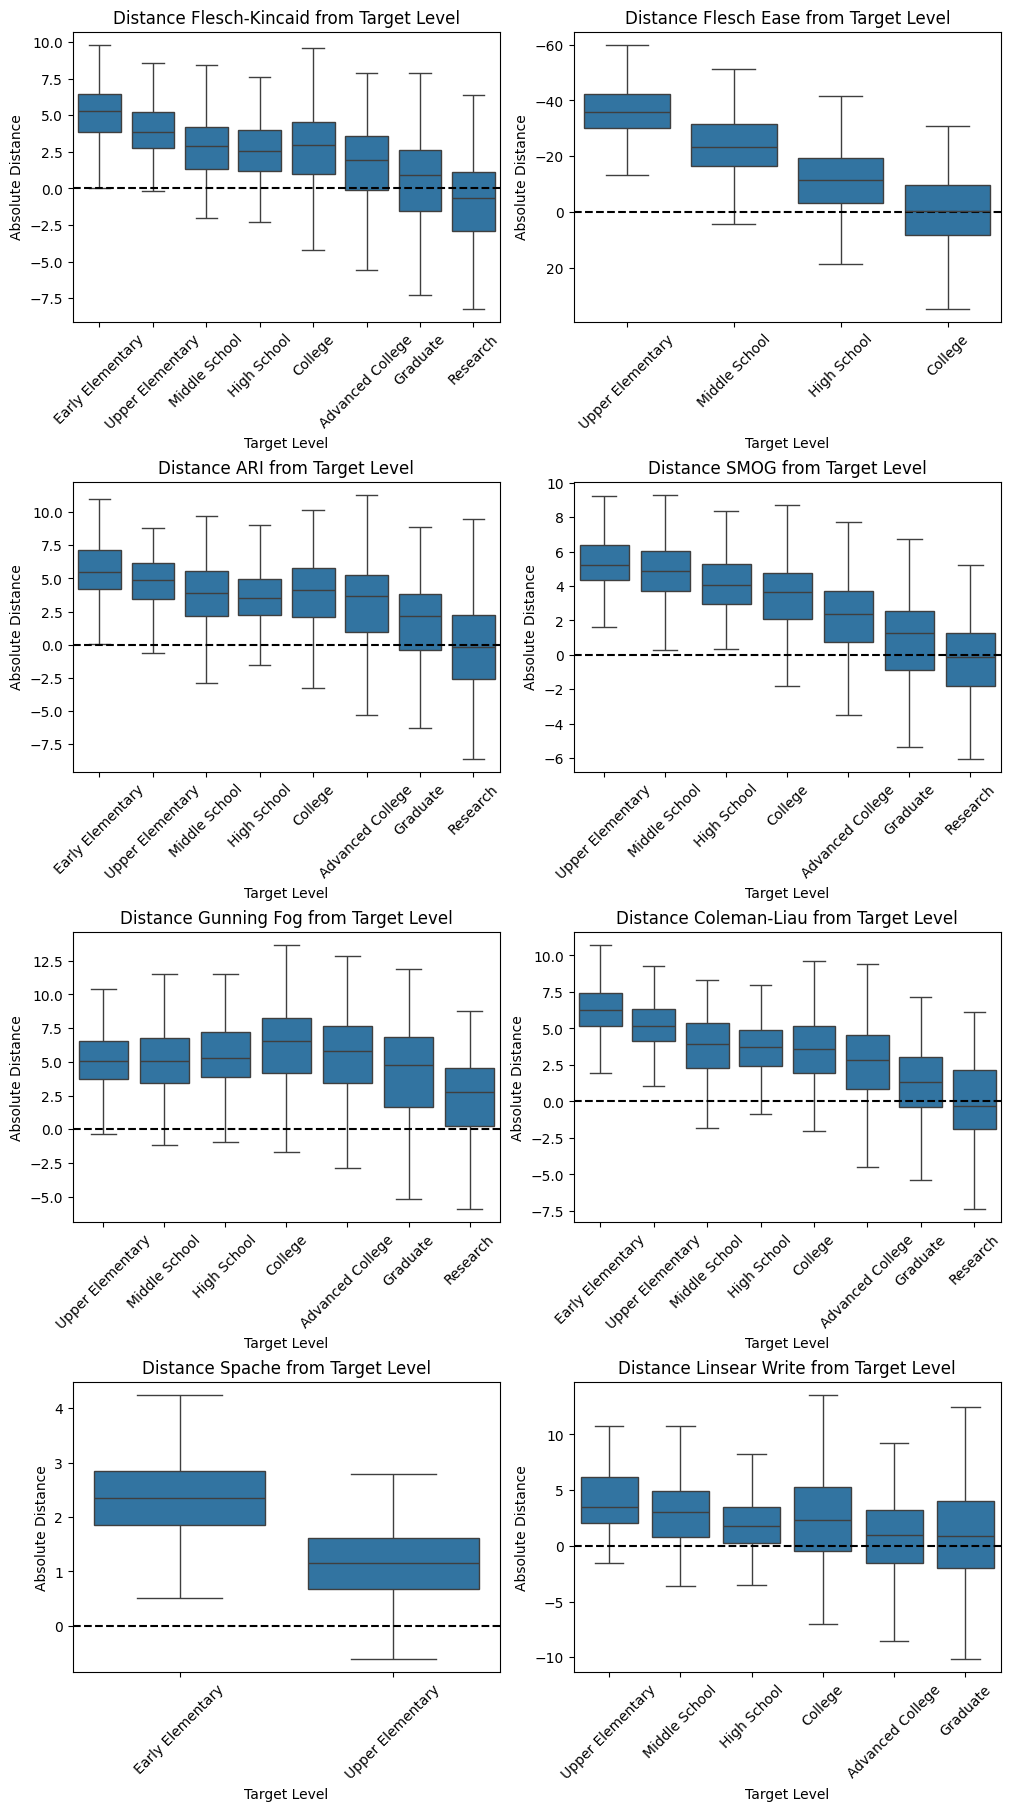

In [17]:
# Signed distance Target - Result

distance_metrics = [
    'Distance Flesch-Kincaid', 'Distance Flesch Ease', 'Distance ARI',
    'Distance SMOG', 'Distance Gunning Fog', 'Distance Coleman-Liau',
    'Distance Spache', 'Distance Linsear Write'
]

n_metrics = len(distance_metrics)
n_cols = 2
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 18), constrained_layout=True)
axes = axes.flatten() # Flatten to easily iterate

for i, metric in enumerate(distance_metrics):
    plot_df = df_all[['Target Level', metric]].dropna()
    
    # Filter levels actually present in the current data
    present_levels = sorted(
        plot_df['Target Level'].unique(),
        key=lambda x: READABILITY_LEVELS.index(x)
    )

    # Apply only present levels as categorical ordering
    plot_df['Target Level'] = pd.Categorical(
        plot_df['Target Level'],
        categories=present_levels,
        ordered=True
    )

    sns.boxplot(data=plot_df, x='Target Level', y=metric, ax=axes[i], showfliers=False)
    axes[i].set_title(metric + ' from Target Level')
    axes[i].set_xlabel('Target Level')
    axes[i].set_ylabel('Absolute Distance')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].axhline(0, color='black', linewidth=1.5, linestyle='--')
    
    if metric == 'Distance Flesch Ease':
        axes[i].invert_yaxis()

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("readability_plots_distance8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [19]:
df_allcpy = df_all.copy()

In [20]:
distance_metrics_adapted = [
    'Distance Flesch-Kincaid Adapted', 'Distance Flesch Ease Adapted', 'Distance ARI Adapted',
    'Distance SMOG Adapted', 'Distance Gunning Fog Adapted', 'Distance Coleman-Liau Adapted',
    'Distance Spache Adapted', 'Distance Linsear Write Adapted'
]

In [21]:
df_allcpy['Mean Distance'] = df_allcpy[distance_metrics_adapted].mean(axis=1)

In [22]:
# Application of ANOVA
model = ols('Q("Mean Distance") ~ C(Technique) + C(Topic) + C(Q("Target Level")) + C(Q("Output Length")) + C(Model)', data=df_allcpy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq      df           F         PR(>F)
C(Technique)            1.302512     4.0   17.928747   2.080389e-14
C(Topic)                1.660060     4.0   22.850310   2.242678e-18
C(Q("Target Level"))   18.033030     7.0  141.840091  2.516846e-162
C(Q("Output Length"))   0.068153     3.0    1.250811   2.898542e-01
C(Model)                0.422144     1.0   23.242820   1.565159e-06
Residual               28.696489  1580.0         NaN            NaN


In [23]:
df_allcpy

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Distance Linsear Write,Distance Flesch-Kincaid Adapted,Distance Flesch Ease Adapted,Distance ARI Adapted,Distance Coleman-Liau Adapted,Distance Gunning Fog Adapted,Distance SMOG Adapted,Distance Spache Adapted,Distance Linsear Write Adapted,Mean Distance
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,...,NaN,0.223061,NaN,0.225871,0.264366,NaN,NaN,1.262707,NaN,0.494001
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,...,NaN,0.034742,NaN,0.038962,0.119531,NaN,NaN,0.257242,NaN,0.112619
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,...,NaN,0.144786,NaN,0.191787,0.226493,NaN,NaN,0.877633,NaN,0.360174
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,...,NaN,0.101754,NaN,0.151535,0.226759,NaN,NaN,0.658551,NaN,0.284650
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,...,2.375,0.297917,0.5995,0.357093,0.427013,0.534373,0.532067,0.880561,0.215909,0.480554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Few-Shot,nutrition,Graduate,200,llama3.1:8b,"Example 1:\nCosmology (from the Greek kosmos, ...",NaN,"Here's a paragraph on ""nutrition"" written in a...",20.875211,-0.456526,...,5.250,0.215289,NaN,0.379968,0.095148,0.728589,0.408592,NaN,0.477273,0.384143
1596,Few-Shot,nutrition,Research,50,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Here's a paragraph about nutrition:\n\nNutriti...,21.326923,-11.531923,...,NaN,0.184829,NaN,0.311166,0.228365,0.582769,0.303376,NaN,NaN,0.322101
1597,Few-Shot,nutrition,Research,100,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,The study of nutrition dates back to ancient c...,17.522392,3.989361,...,NaN,0.026534,NaN,0.054233,0.142784,0.328429,0.038167,NaN,NaN,0.118029
1598,Few-Shot,nutrition,Research,150,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Example:\n\nNutritional systems have been unde...,18.220208,2.853907,...,NaN,0.012234,NaN,0.015785,0.004056,0.397041,0.107266,NaN,NaN,0.107276


In [24]:
# Application of Tukey HSD

for factor in ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model']:
    tukey = pairwise_tukeyhsd(df_allcpy['Mean Distance'], df_allcpy[factor], alpha=0.05)
    print(f"\nTukey HSD for {factor}")
    print(tukey.summary())


Tukey HSD for Technique
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
         Chain-of-Thought Chain-of-Thought-Advanced  -0.0383  0.045 -0.0761 -0.0005   True
         Chain-of-Thought                  Few-Shot  -0.0692    0.0  -0.107 -0.0314   True
         Chain-of-Thought                  Two-Step  -0.0056 0.9943 -0.0434  0.0322  False
         Chain-of-Thought                 Zero-Shot  -0.0634    0.0 -0.1012 -0.0256   True
Chain-of-Thought-Advanced                  Few-Shot  -0.0308 0.1698 -0.0686   0.007  False
Chain-of-Thought-Advanced                  Two-Step   0.0327 0.1262 -0.0051  0.0705  False
Chain-of-Thought-Advanced                 Zero-Shot   -0.025 0.3682 -0.0628  0.0127  False
                 Few-Shot                  Two-Step   0.0635    0

In [25]:
# Output of top and tail combinations based on Mean Distance
df_allcpy['Output Length'] = df_allcpy['Output Length'].astype(str)

df_allcpy['Combo'] = (
    df_allcpy['Technique'] + " | " +
    df_allcpy['Target Level'] + " | " +
    df_allcpy['Topic'] + " | " +
    df_allcpy['Output Length'] + " | " +
    df_allcpy['Model']
)

best = df_allcpy.groupby('Combo')['Mean Distance'].mean().sort_values()

print(best)

Combo
Zero-Shot | Upper Elementary | human aging | 50 | mistral:instruct                      0.040516
Few-Shot | Research | prehistory | 100 | mistral:instruct                               0.042052
Few-Shot | Research | astronomy | 50 | mistral:instruct                                 0.046887
Chain-of-Thought-Advanced | Advanced College | prehistory | 150 | llama3.1:8b           0.047852
Few-Shot | Graduate | prehistory | 100 | mistral:instruct                               0.056747
                                                                                          ...   
Two-Step | College | computer security | 150 | llama3.1:8b                              0.976435
Chain-of-Thought-Advanced | Early Elementary | computer security | 150 | llama3.1:8b    0.990830
Two-Step | Upper Elementary | computer security | 150 | mistral:instruct                1.013953
Chain-of-Thought | Upper Elementary | prehistory | 100 | mistral:instruct               1.014737
Two-Step | Upper Element

In [26]:
print(best.head(30))

Combo
Zero-Shot | Upper Elementary | human aging | 50 | mistral:instruct                           0.040516
Few-Shot | Research | prehistory | 100 | mistral:instruct                                    0.042052
Few-Shot | Research | astronomy | 50 | mistral:instruct                                      0.046887
Chain-of-Thought-Advanced | Advanced College | prehistory | 150 | llama3.1:8b                0.047852
Few-Shot | Graduate | prehistory | 100 | mistral:instruct                                    0.056747
Zero-Shot | Research | astronomy | 200 | llama3.1:8b                                         0.057354
Chain-of-Thought | Middle School | human aging | 200 | mistral:instruct                      0.057776
Few-Shot | Research | astronomy | 200 | mistral:instruct                                     0.060178
Chain-of-Thought-Advanced | High School | human aging | 100 | mistral:instruct               0.061761
Few-Shot | Middle School | nutrition | 150 | llama3.1:8b                    

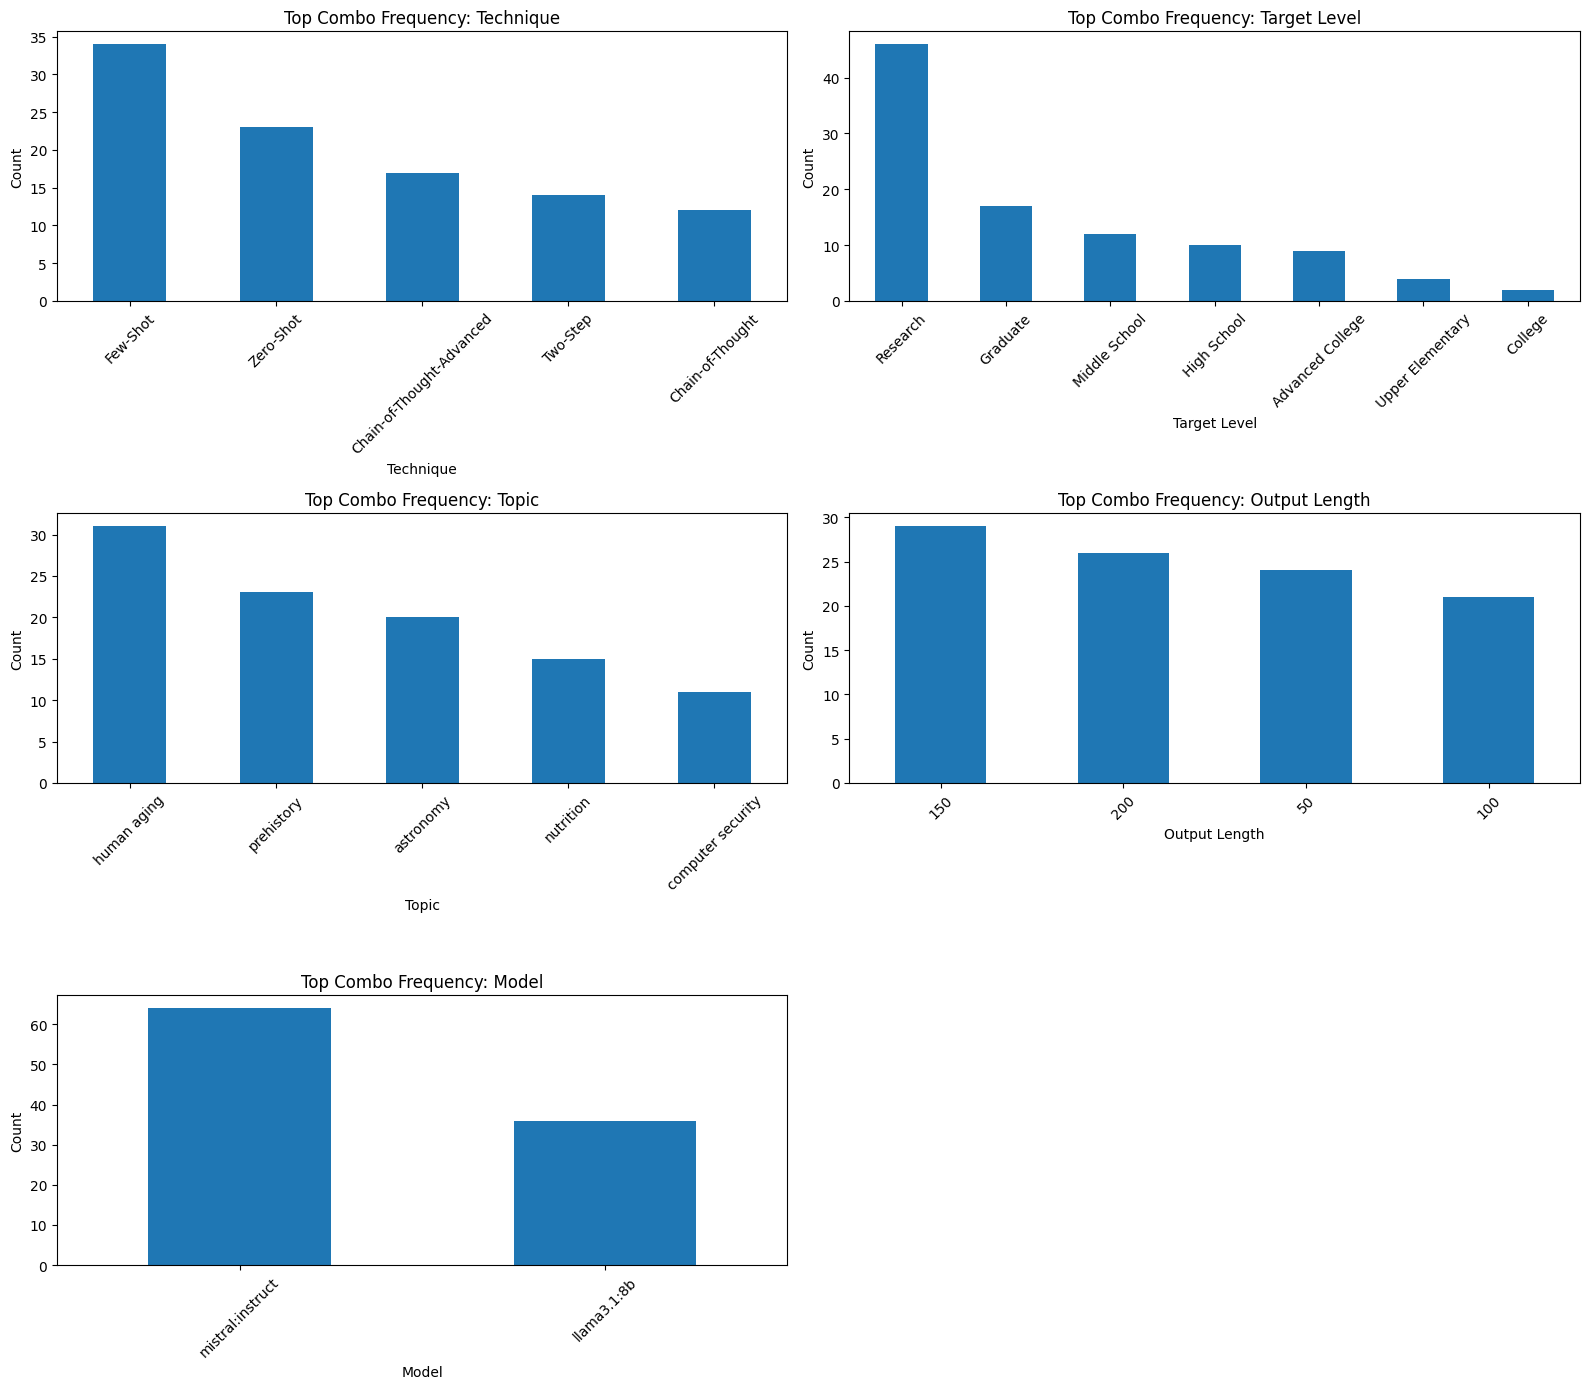

In [28]:
# Plotting statistics about factors of best performing combinations using PyPlot
resultscombo = pd.DataFrame(best.head(100))
resultscombo.columns = ['Mean Distance']
resultscombo = resultscombo.reset_index()
resultscombo.rename(columns={'index': 'Combo'}, inplace=True)

resultscombo[['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']] = resultscombo['Combo'].str.split(" \| ", expand=True)

params = ['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']
counts = {param: resultscombo[param].value_counts() for param in params}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts[param].plot(kind='bar', ax=ax)
    ax.set_title(f"Top Combo Frequency: {param}")
    ax.set_ylabel("Count")
    ax.set_xlabel(param)
    ax.tick_params(axis='x', rotation=45)

if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("top_combo_readability8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

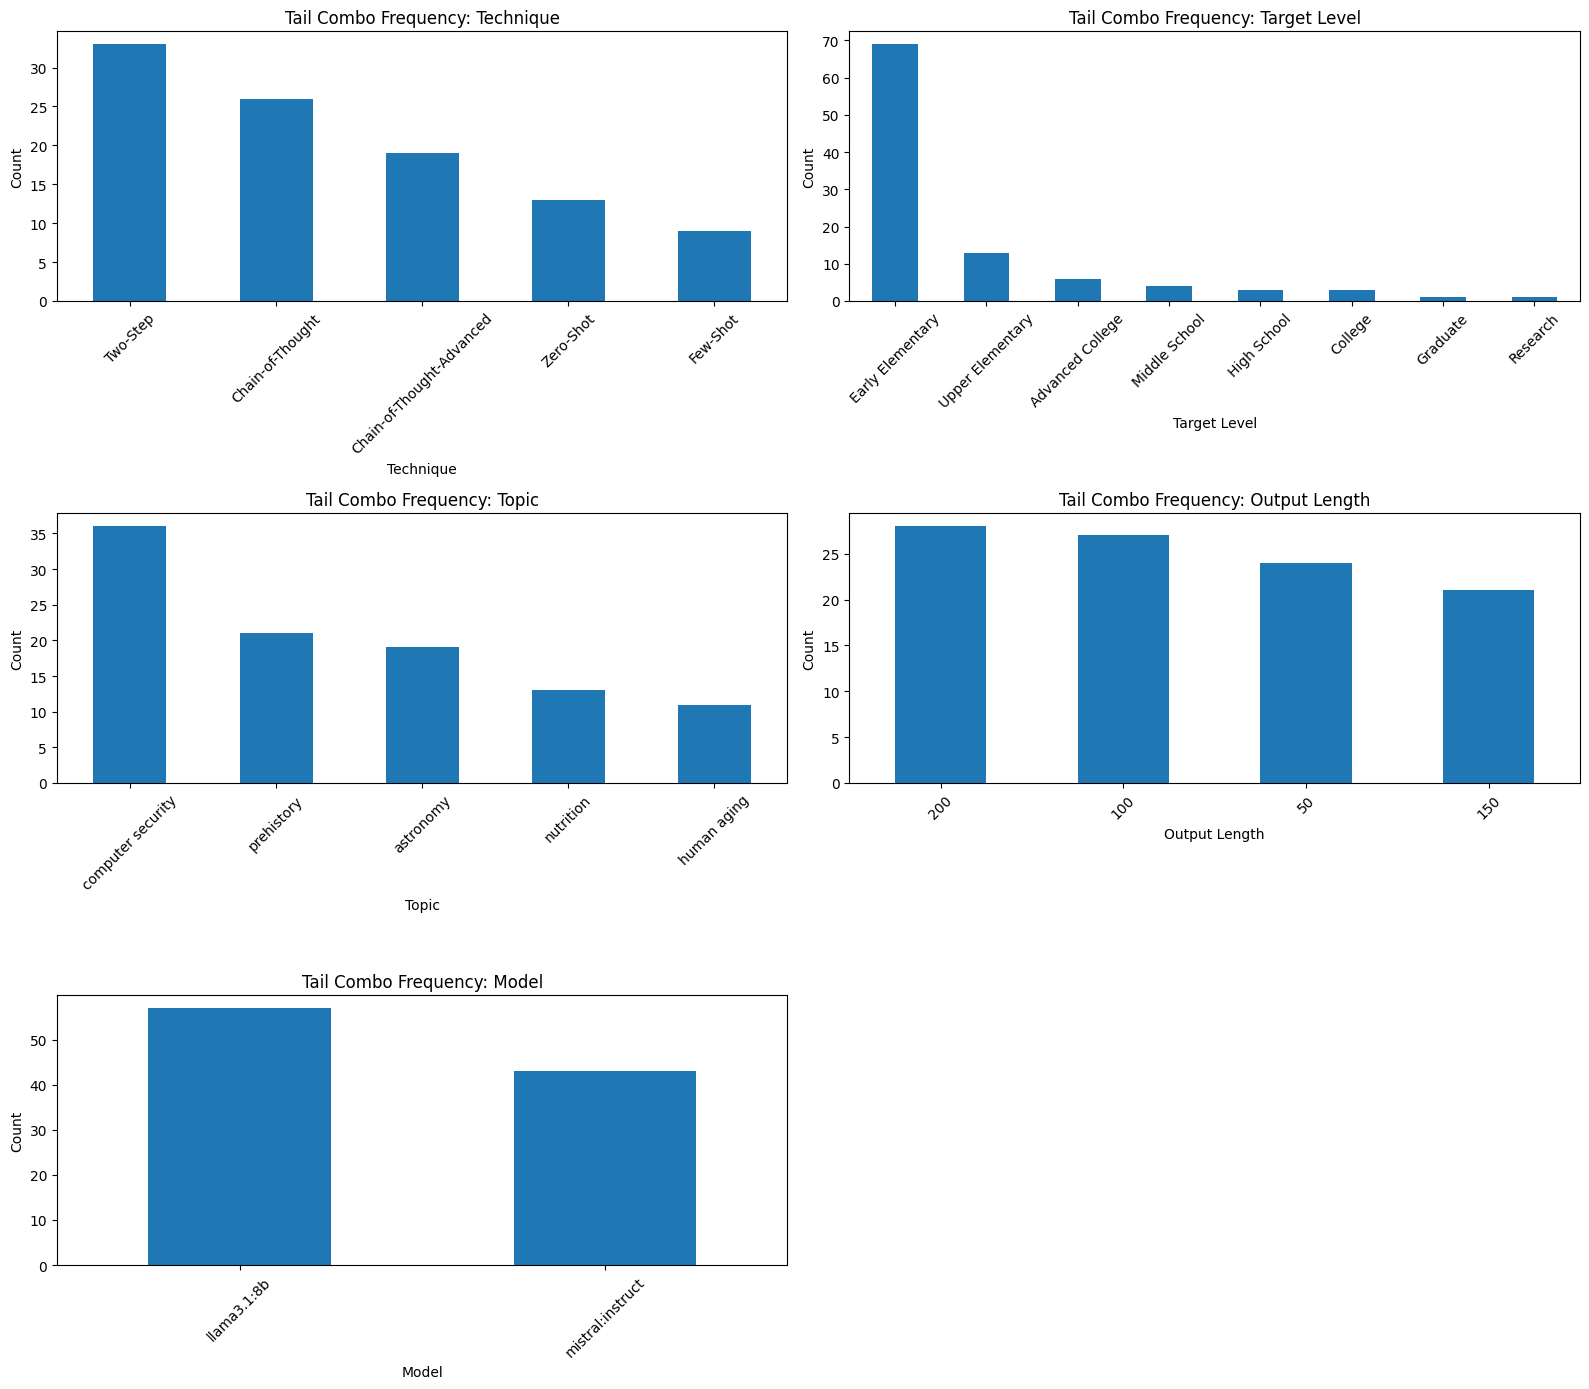

In [29]:
# Plotting statistics about factors of worst performing combinations using PyPlot
resultscombo = pd.DataFrame(best.tail(100))
resultscombo.columns = ['Mean Distance']
resultscombo = resultscombo.reset_index()
resultscombo.rename(columns={'index': 'Combo'}, inplace=True)

resultscombo[['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']] = resultscombo['Combo'].str.split(" \| ", expand=True)

params = ['Technique', 'Target Level', 'Topic', 'Output Length', 'Model']
counts = {param: resultscombo[param].value_counts() for param in params}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts[param].plot(kind='bar', ax=ax)
    ax.set_title(f"Tail Combo Frequency: {param}")
    ax.set_ylabel("Count")
    ax.set_xlabel(param)
    ax.tick_params(axis='x', rotation=45)

if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("tail_combo_readability8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Additional functions for calculating semantic similarity

def extract_summary(prompt):
    try:
        return prompt.split(":\n\n", 1)[-1].strip()
    except Exception:
        return ""

def compute_similarity(row):
    original = row['Original Summary']
    rewritten = row['Text']
    if not original or not rewritten:
        return None
    embeddings = model.encode([original, rewritten], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return round(similarity, 3)

In [30]:
# Semantic similarity for Two-Step prompting technique between initial output and rewritten one

model = SentenceTransformer('all-MiniLM-L6-v2')

df_two_step = df_all[df_all['Technique'] == 'Two-Step'].copy()

df_two_step['Original Summary'] = df_two_step['Rewrite Prompt'].apply(extract_summary)

df_two_step['Semantic Similarity'] = df_two_step.apply(compute_similarity, axis=1)

threshold = 0.75
df_two_step['Meaning Preserved'] = df_two_step['Semantic Similarity'] >= threshold

columns_for_stats = ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model', 
                     'Original Summary', 'Text', 'Semantic Similarity', 'Meaning Preserved']

df_result = df_two_step[columns_for_stats]

In [31]:
df_result

,Technique,Topic,Target Level,Output Length,Model,Original Summary,Text,Semantic Similarity,Meaning Preserved
480,Two-Step,human aging,Early Elementary,50,llama3.1:8b,"Human aging is a complex, multifaceted process...",Here is the rewritten text:\n\nAs we get older...,0.605,False
481,Two-Step,human aging,Early Elementary,100,llama3.1:8b,Human aging is a complex and multifaceted proc...,Here's the rewritten text:\n\nAs people get ol...,0.720,False
482,Two-Step,human aging,Early Elementary,150,llama3.1:8b,Human aging is a complex and multifaceted proc...,Here's a rewritten version of the text at an E...,0.734,False
483,Two-Step,human aging,Early Elementary,200,llama3.1:8b,Human aging is a complex and multifaceted proc...,Here's a rewritten version of the text at an E...,0.739,False
484,Two-Step,human aging,Upper Elementary,50,llama3.1:8b,Human aging is a complex process characterized...,Here is a rewritten version of the text at an ...,0.633,False
...,...,...,...,...,...,...,...,...,...
1115,Two-Step,nutrition,Graduate,200,mistral:instruct,"Nutrition, a fundamental aspect of life, revol...",Food and our bodies go hand in hand – that's n...,0.910,True
1116,Two-Step,nutrition,Research,50,mistral:instruct,Nutrition refers to the process of consuming a...,Eating right means consuming food that helps o...,0.751,True
1117,Two-Step,nutrition,Research,100,mistral:instruct,Nutrition refers to the process of providing o...,Nutrition is about getting the right food for ...,0.922,True
1118,Two-Step,nutrition,Research,150,mistral:instruct,"Nutrition, essential for life, encompasses the...","Life's foundation lies in proper nutrition, wh...",0.923,True


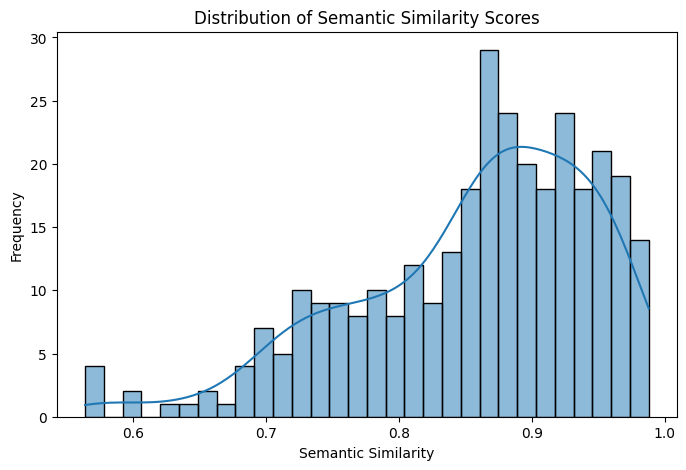

In [33]:
# Plotting of semantic scors distribution for Two-Step technique
plt.figure(figsize=(8,5))
sns.histplot(df_result['Semantic Similarity'].dropna(), bins=30, kde=True)

plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.savefig("semantic_similarity8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# Additional function to calculate similarity
def compute_similarity(row):
    topic = row['Topic']
    text = row['Text']
    if not topic or not text:
        return None
    embeddings = model.encode([topic, text], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return round(similarity, 3)

In [34]:
# Plotting of semantic scors distribution for Topic - Output
model = SentenceTransformer('all-MiniLM-L6-v2')

df_all_filtered = df_allcpy.dropna(subset=['Topic', 'Text']).copy()

df_all_filtered['Semantic Similarity'] = df_all_filtered.apply(compute_similarity, axis=1)

threshold = 0.75
df_all_filtered['Meaning Preserved'] = df_all_filtered['Semantic Similarity'] >= threshold
df_result2 = df_all_filtered

In [35]:
df_result2

,Technique,Topic,Target Level,Output Length,Model,Prompt,Rewrite Prompt,Text,Flesch-Kincaid,Flesch Ease,...,Distance ARI Adapted,Distance Coleman-Liau Adapted,Distance Gunning Fog Adapted,Distance SMOG Adapted,Distance Spache Adapted,Distance Linsear Write Adapted,Mean Distance,Combo,Semantic Similarity,Meaning Preserved
0,Few-Shot,human aging,Early Elementary,50,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"A person grows older, just like how a seed bec...",6.015104,75.804149,...,0.225871,0.264366,NaN,NaN,1.262707,NaN,0.494001,Few-Shot | Early Elementary | human aging | 50...,0.723,False
1,Few-Shot,human aging,Early Elementary,100,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,Grandma and Grandpa walk in their garden. They...,2.625357,91.585027,...,0.038962,0.119531,NaN,NaN,0.257242,NaN,0.112619,Few-Shot | Early Elementary | human aging | 10...,0.538,False
2,Few-Shot,human aging,Early Elementary,150,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"Humans grow older, just like how cats and dogs...",4.606149,85.905642,...,0.191787,0.226493,NaN,NaN,0.877633,NaN,0.360174,Few-Shot | Early Elementary | human aging | 15...,0.590,False
3,Few-Shot,human aging,Early Elementary,200,mistral:instruct,Example 1:\nCat and Dog walk. They walk in the...,NaN,"In our town, there are people who have lived f...",3.831574,87.629583,...,0.151535,0.226759,NaN,NaN,0.658551,NaN,0.284650,Few-Shot | Early Elementary | human aging | 20...,0.600,False
4,Few-Shot,human aging,Upper Elementary,50,mistral:instruct,Example 1:\nAs Johnson worked on math problems...,NaN,"As Tim aged, his curiosity never waned. He ask...",10.362500,47.040021,...,0.357093,0.427013,0.534373,0.532067,0.880561,0.215909,0.480554,Few-Shot | Upper Elementary | human aging | 50...,0.636,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Few-Shot,nutrition,Graduate,200,llama3.1:8b,"Example 1:\nCosmology (from the Greek kosmos, ...",NaN,"Here's a paragraph on ""nutrition"" written in a...",20.875211,-0.456526,...,0.379968,0.095148,0.728589,0.408592,NaN,0.477273,0.384143,Few-Shot | Graduate | nutrition | 200 | llama3...,0.661,False
1596,Few-Shot,nutrition,Research,50,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Here's a paragraph about nutrition:\n\nNutriti...,21.326923,-11.531923,...,0.311166,0.228365,0.582769,0.303376,NaN,NaN,0.322101,Few-Shot | Research | nutrition | 50 | llama3....,0.566,False
1597,Few-Shot,nutrition,Research,100,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,The study of nutrition dates back to ancient c...,17.522392,3.989361,...,0.054233,0.142784,0.328429,0.038167,NaN,NaN,0.118029,Few-Shot | Research | nutrition | 100 | llama3...,0.652,False
1598,Few-Shot,nutrition,Research,150,llama3.1:8b,"Example 1:\nAn electrostatic generator, or ele...",NaN,Example:\n\nNutritional systems have been unde...,18.220208,2.853907,...,0.015785,0.004056,0.397041,0.107266,NaN,NaN,0.107276,Few-Shot | Research | nutrition | 150 | llama3...,0.616,False


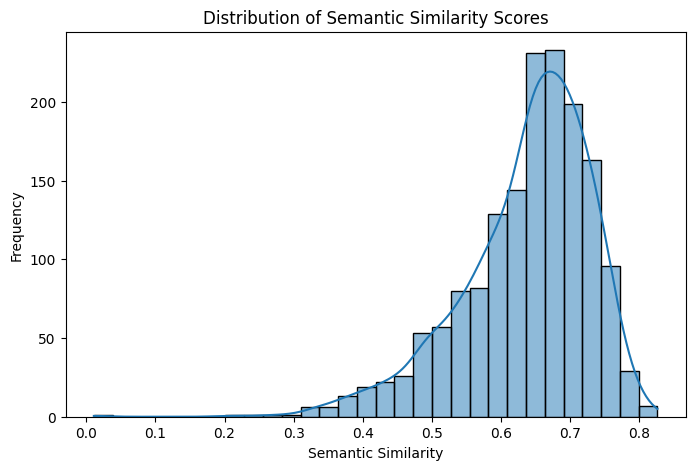

In [37]:
# Plot of Semantic similarity between Topic and Output between different prompting techniques
plt.figure(figsize=(8,5))
sns.histplot(df_result2['Semantic Similarity'].dropna(), bins=30, kde=True)

plt.title('Distribution of Semantic Similarity Scores')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.savefig("semantic_similarity_topic8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

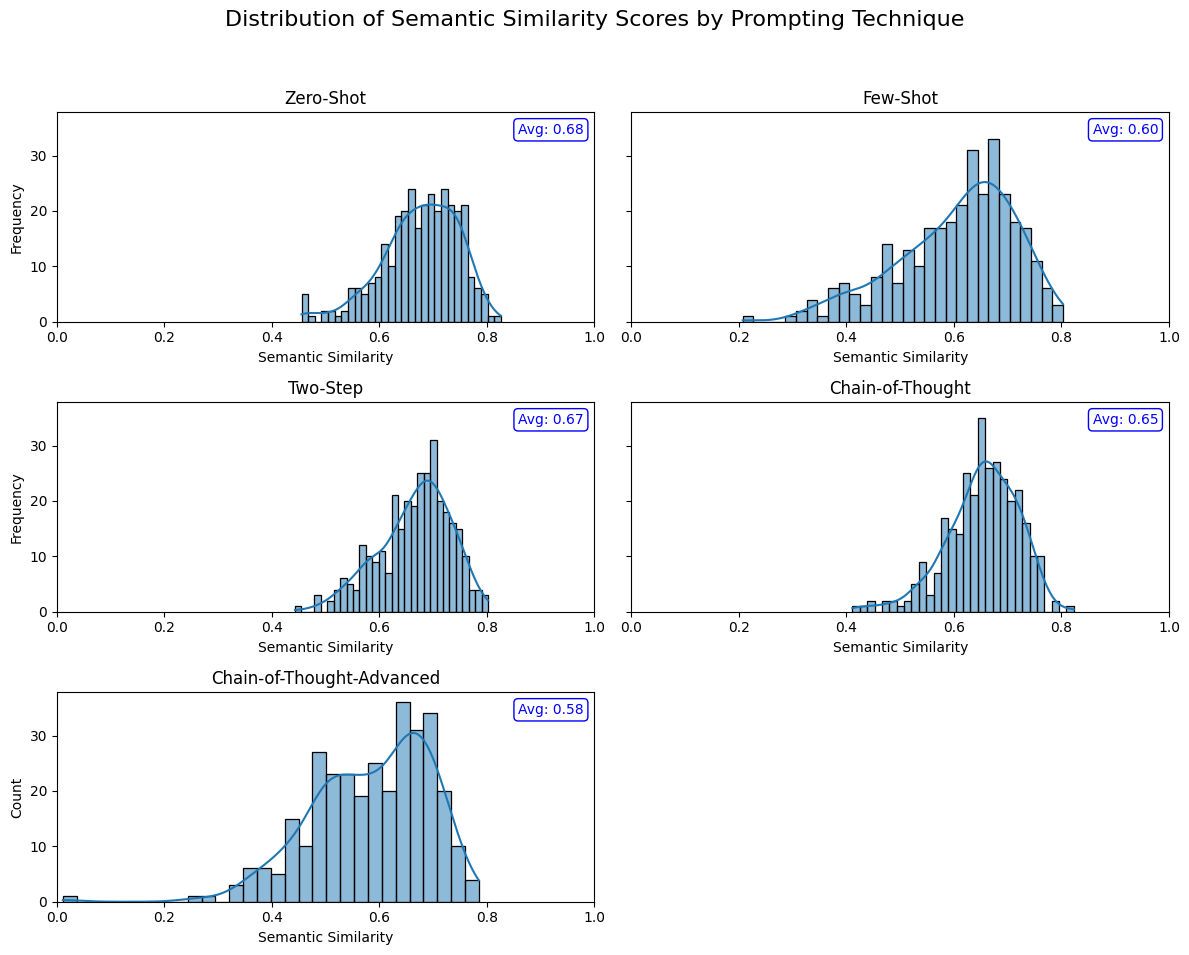

In [38]:
# Distribution of Similarity Scores between Prompting techniques

prompting_techniques = ['Zero-Shot', 'Few-Shot', 'Two-Step', 'Chain-of-Thought', 'Chain-of-Thought-Advanced']

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=True)

for ax, technique in zip(axes.flat, prompting_techniques):
    subset = df_result2[df_result2['Technique'] == technique]
    data = subset['Semantic Similarity'].dropna()
    
    sns.histplot(data, bins=30, kde=True, ax=ax)
    
    mean_similarity = data.mean()

    ax.text(0.98, 0.95, f'Avg: {mean_similarity:.2f}', transform=ax.transAxes,
            color='blue', ha='right', va='top', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'))

    ax.set_title(technique)
    ax.set_xlabel('Semantic Similarity')
    ax.set_xlim(0, 1)

fig.delaxes(axes[2, 1])
axes[0, 0].set_ylabel('Frequency')
axes[1, 0].set_ylabel('Frequency')

plt.suptitle('Distribution of Semantic Similarity Scores by Prompting Technique', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("semantic_similarity_topic_prompting_technique8B.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [39]:
# Statistical analysis of semantic similarity using ANOVA

model = ols('Q("Semantic Similarity") ~ C(Technique) + C(Topic) + C(Q("Target Level")) + C(Q("Output Length")) + C(Model)', data=df_result2).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq      df          F        PR(>F)
C(Technique)            2.039888     4.0  77.992993  1.970772e-60
C(Topic)                0.434016     4.0  16.594134  2.498013e-13
C(Q("Target Level"))    1.023839     7.0  22.368821  5.084710e-29
C(Q("Output Length"))   0.069909     3.0   3.563877  1.372028e-02
C(Model)                0.138031     1.0  21.109860  4.681283e-06
Residual               10.331130  1580.0        NaN           NaN


In [40]:
# Statistical analysis of semantic similarity using Tukey HSD

for factor in ['Technique', 'Topic', 'Target Level', 'Output Length', 'Model']:
    print(f"\nTukey HSD for {factor}")
    
    df_result2_tukey = df_result2.filter(items=['Semantic Similarity', factor]).dropna()
    tukey = pairwise_tukeyhsd(df_result2_tukey['Semantic Similarity'], df_result2_tukey[factor], alpha=0.05)
    print(tukey.summary())


Tukey HSD for Technique
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
         Chain-of-Thought Chain-of-Thought-Advanced  -0.0683    0.0  -0.087 -0.0495   True
         Chain-of-Thought                  Few-Shot  -0.0481    0.0 -0.0668 -0.0294   True
         Chain-of-Thought                  Two-Step   0.0129   0.33 -0.0059  0.0316  False
         Chain-of-Thought                 Zero-Shot    0.023 0.0072  0.0043  0.0417   True
Chain-of-Thought-Advanced                  Few-Shot   0.0201 0.0279  0.0014  0.0389   True
Chain-of-Thought-Advanced                  Two-Step   0.0811    0.0  0.0624  0.0998   True
Chain-of-Thought-Advanced                 Zero-Shot   0.0913    0.0  0.0726    0.11   True
                 Few-Shot                  Two-Step    0.061    0

In [ ]:
# Additional techniques for plotting

metric_to_mapping = {
    'Flesch-Kincaid': FLESCH_KINCAID_GRADE,
    'Flesch Ease': FLESCH_READING_EASE,
    'ARI': ARI,
    'SMOG': SMOG_INDEX,
    'Gunning Fog': GUNNING_FOG,
    'Coleman-Liau': COLEMAN_LIAU,
    'Spache': SPACHE,
    'Linsear Write': LINSEAR_WRITE,
}

def invert_mapping(mapping, is_range=False):
    level_to_values = defaultdict(list)
    if is_range:
        for rng, level in mapping.items():
            level_to_values[level].append(rng)
    else:
        for score, level in mapping.items():
            level_to_values[level].append(score)
    return level_to_values

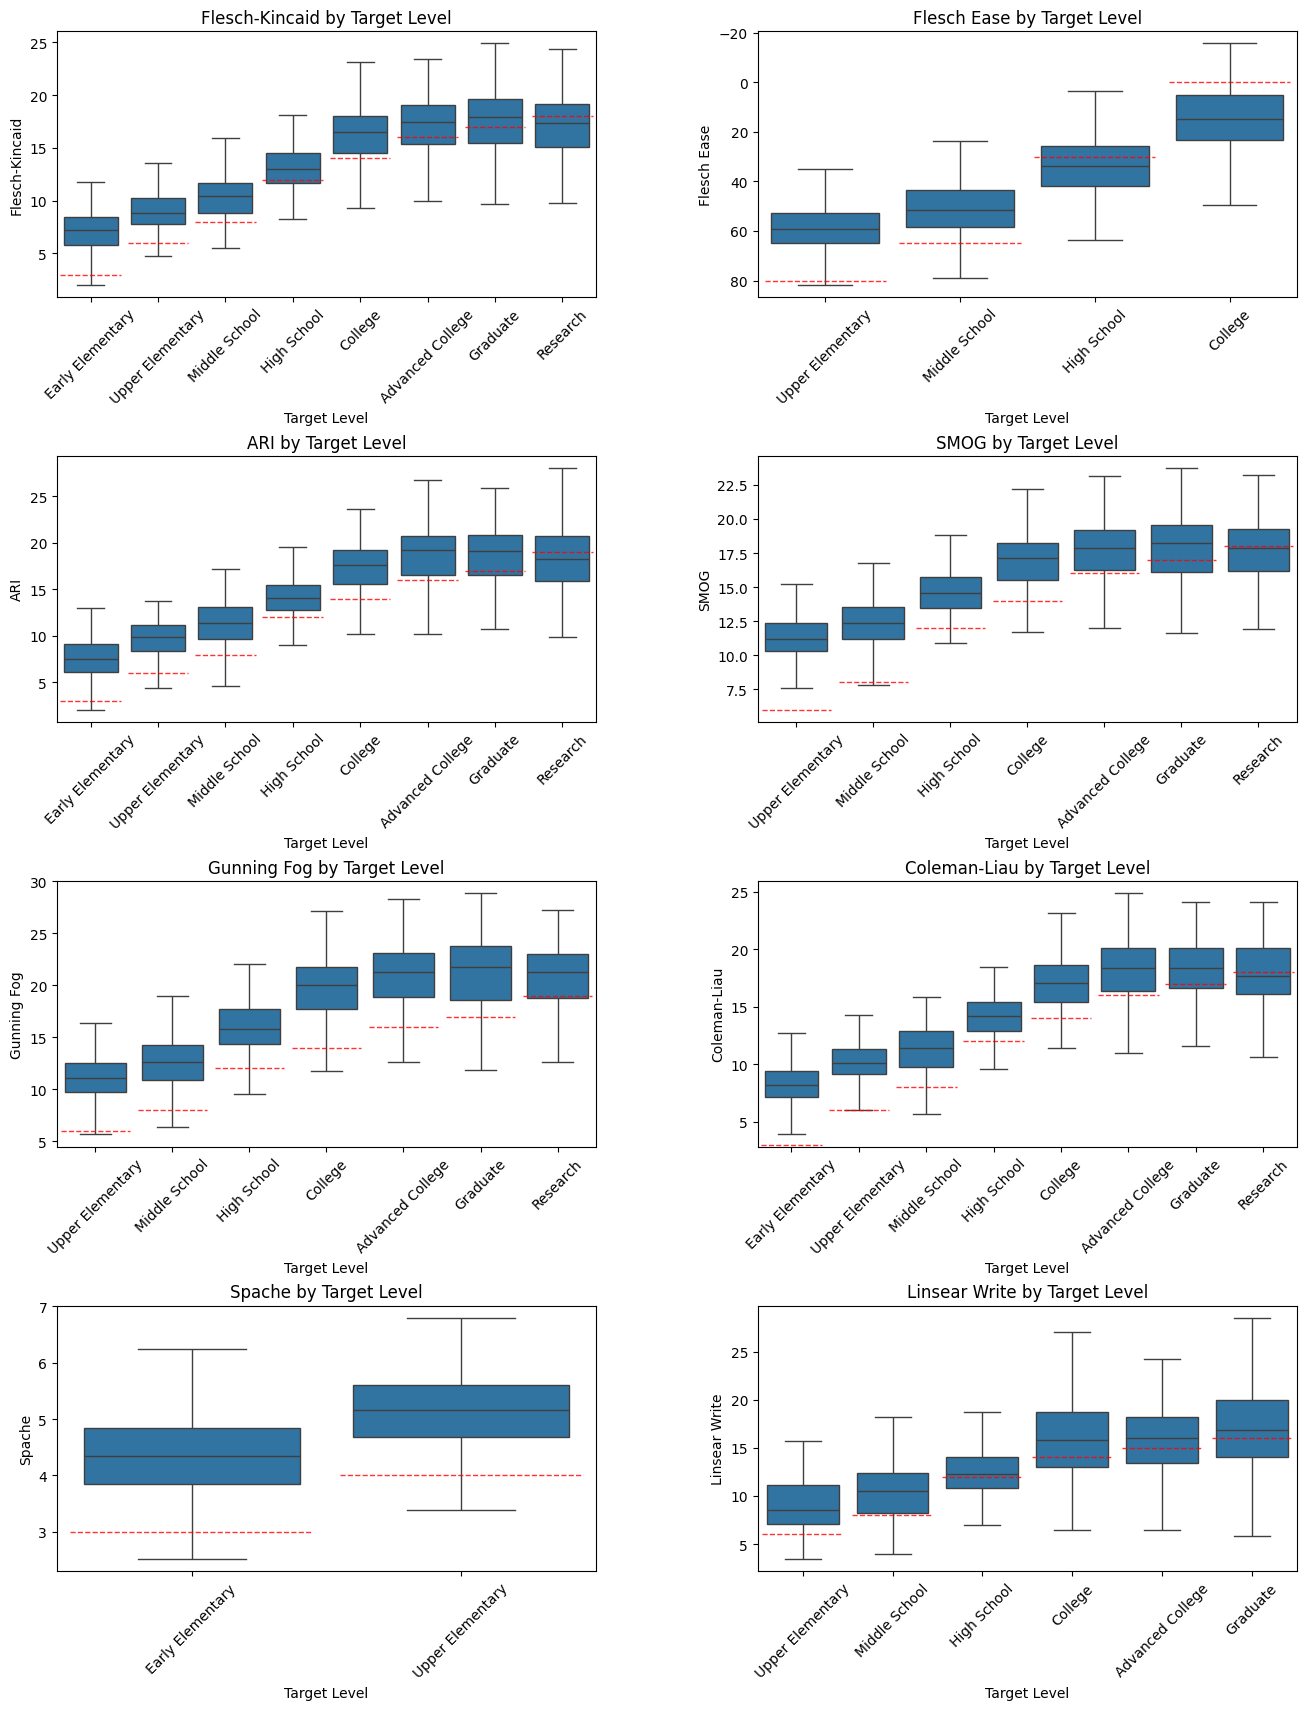

In [41]:
# Plotting of metric scores across Target levels

metrics = list(metric_to_mapping.keys())
flesch_df = df_allcpy[metrics + ['Target Level']].dropna()

n_metrics = len(metrics)
n_cols = 2  
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    mapping = metric_to_mapping[metric]
    is_range = any(isinstance(k, tuple) for k in mapping.keys())
    level_to_values = invert_mapping(mapping, is_range)
    
    supported_levels = set(level_to_values.keys())
    
    df_metric = flesch_df[flesch_df['Target Level'].isin(supported_levels)]

    sns.boxplot(data=df_metric, x='Target Level', y=metric, ax=ax, showfliers=False)
    ax.set_title(f'{metric} by Target Level')
    ax.set_xlabel('Target Level')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    if metric == "Flesch Ease":
        ax.invert_yaxis()

    levels_in_data = df_metric['Target Level'].unique()

    for xtick, level in enumerate(levels_in_data):
        if level in level_to_values:
            values = level_to_values[level]
            if is_range:
                # Reverse of Flesch Ease for easier understanding
                if metric == "Flesch Ease":
                    lower_bounds = [low for (low, _) in values]
                    y = min(lower_bounds)
                else:
                    upper_bounds = [high for (_, high) in values]
                    y = max(upper_bounds)
            else:
                y = max(values)



            ax.axhline(
                y=y,
                xmin=(xtick + 0.05) / len(levels_in_data),
                xmax=(xtick + 0.95) / len(levels_in_data),
                color='red',
                linestyle='--',
                linewidth=1,
                alpha=0.8
            )

# Remove extra axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.6, wspace=0.3)
plt.savefig("target_level_values8B.pdf", format="pdf", bbox_inches="tight")
plt.show()